# **Análisis de Características - `04_analisis_caracteristicas.ipynb`**

### **🎯 Objetivo del Notebook**
Este notebook tiene como objetivo analizar la relevancia de las características en los datos EEG y aplicar técnicas de reducción de dimensionalidad para mejorar el rendimiento del modelo.  

### **📌 Contexto**
En notebooks anteriores, entrenamos un modelo de Regresión Logística para la clasificación de eventos EEG relacionados con el movimiento de la mano. Sin embargo, la optimización del hiperparámetro `C` no resultó en mejoras significativas, por lo que para conseguir mejores resultados y en base a lo analizado en `01_preprocesamiento` analizaremos y filtraremos las características actuales ya que podrían estar limitando el rendimiento del modelo.  

Antes de probar modelos más complejos (`XGBoost`, `LightGBM`), es crucial mejorar la calidad de los datos. Para ello, en este notebook exploraremos:  
- **La importancia de cada electrodo en la clasificación de eventos EEG.**  
- **La eliminación de características irrelevantes o ruidosas.**  
- **Técnicas de reducción de dimensionalidad, como PCA o análisis de varianza.**  
- **El impacto de estas mejoras en el rendimiento de la Regresión Logística.**  

### **🚀 Flujo de Trabajo en este Notebook***
1️⃣ **Carga de datos preprocesados**  
2️⃣ **Eliminación de Outliers**  
3️⃣ **Análisis de la Varianza**  
4️⃣ **Análisis de Correlaciones y Reducción de Dimensionalidad con PCA si hay señales altamente correlacionadas**  
5️⃣ **Análisis de la importancia de las características y Selección de características basada en relevancia**   
6️⃣ **Comparación del rendimiento antes y después del nuevo preprocesamiento aplicado**  
7️⃣ **Conclusiones y próximos pasos**  

## **1. Carga de Datos Preprocesados**

Además de cargar los datos verificamos que se mantengan la media ≈ 0 y std ≈ 1.

In [17]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from collections import Counter

# Definir la ruta de los datos preprocesados
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"

# Cargar los datos preprocesados
with open(os.path.join(processed_path, "preprocessed_data.pkl"), "rb") as f:
    X_train, y_train, X_valid, y_valid = pickle.load(f)

# Verificar normalización
print("Media después del preprocesamiento:", np.mean(X_train, axis=0))
print("Desviación estándar después del preprocesamiento:", np.std(X_train, axis=0))

Media después del preprocesamiento: [ 2.76186120e-17  5.37028566e-18  1.15844734e-16 -4.90997546e-17
  9.70487338e-17  7.40332238e-17  4.79489791e-18 -5.33192648e-17
  1.25626325e-16  1.99467753e-17  6.98137136e-17  2.79063059e-17
  1.85466651e-16  4.75653873e-17 -6.44434280e-17 -2.08098569e-17
  1.30421223e-17 -7.67183666e-18  3.39958262e-17 -2.30155100e-18
 -1.93234386e-17  3.26053058e-18  1.96303121e-16 -7.82527339e-17
  8.66917543e-17  4.59351220e-17  5.27438770e-18 -3.72084078e-17
 -5.29356730e-17 -2.92488773e-17 -2.97763160e-17 -3.14545303e-17]
Desviación estándar después del preprocesamiento: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


## **2. Eliminación de Outliers y Evaluación del Impacto del Filtrado en el Modelo**

Ya detectamos **valores extremos** en `01_preprocesamiento.ipynb`, por lo que aquí aplicamos un filtro basado en Z-score.

In [37]:
# Calcular Z-score
z_scores = np.abs(zscore(X_train))

# Definir umbral (Z > 3 indica outliers)
threshold = 3
outliers = (z_scores > threshold).sum(axis=1)

# Filtrar filas con menos de 5 outliers
X_train_filtered = X_train[outliers < 5]
y_train_filtered = y_train[outliers < 5]

print(f"Datos antes: {X_train.shape[0]}")
print(f"Datos después de eliminar outliers: {X_train_filtered.shape[0]}")



# Evaluar el rendimiento tras eliminar outliers

# Convertir y_train_filtered a NumPy array
if isinstance(y_train_filtered, pd.DataFrame):
    y_train_filtered = y_train_filtered.values

# Diccionario para almacenar los resultados AUC por evento
auc_results_outliers = {}

print("\n**Comparación de Modelos con y sin Eliminación de Outliers**")

for event in range(y_train_filtered.shape[1]):  
    event_name = event_names[event]
    print(f"\nEvaluando Modelo para {event_name}...")

    # Seleccionar la etiqueta correspondiente (convertir a 1D)
    y_train_event = y_train_filtered[:, event]
    
    # Modelo con todas las características (sin filtrar outliers)
    model_original = LogisticRegression(max_iter=1000)
    auc_score_original = cross_val_score(model_original, X_train_var, y_train_array[:, event], cv=5, scoring="roc_auc").mean()

    # Modelo tras eliminar outliers
    model_filtered = LogisticRegression(max_iter=1000)
    auc_score_filtered = cross_val_score(model_filtered, X_train_filtered, y_train_event, cv=5, scoring="roc_auc").mean()

    # Guardar resultados
    auc_results_outliers[event_name] = {"Original": auc_score_original, "Sin Outliers": auc_score_filtered}

    # Imprimir resultados del evento
    print(f"AUC Original: {auc_score_original:.4f} | AUC Sin Outliers: {auc_score_filtered:.4f}")

# Mostrar resumen final
print("\n**Resumen Final de AUC-ROC con y sin Eliminación de Outliers**")
for event, scores in auc_results_outliers.items():
    print(f"{event}: AUC Original = {scores['Original']:.4f} | AUC Sin Outliers = {scores['Sin Outliers']:.4f}")


Datos antes: 1185498
Datos después de eliminar outliers: 1172937

**Comparación de Modelos con y sin Eliminación de Outliers**

Evaluando Modelo para HandStart...
AUC Original: 0.7552 | AUC Sin Outliers: 0.7552

Evaluando Modelo para FirstDigitTouch...
AUC Original: 0.7741 | AUC Sin Outliers: 0.7741

Evaluando Modelo para BothStartLoadPhase...
AUC Original: 0.7365 | AUC Sin Outliers: 0.7365

Evaluando Modelo para LiftOff...
AUC Original: 0.7485 | AUC Sin Outliers: 0.7485

Evaluando Modelo para Replace...
AUC Original: 0.8589 | AUC Sin Outliers: 0.8589

Evaluando Modelo para BothReleased...
AUC Original: 0.7839 | AUC Sin Outliers: 0.7839

**Resumen Final de AUC-ROC con y sin Eliminación de Outliers**
HandStart: AUC Original = 0.7552 | AUC Sin Outliers = 0.7552
FirstDigitTouch: AUC Original = 0.7741 | AUC Sin Outliers = 0.7741
BothStartLoadPhase: AUC Original = 0.7365 | AUC Sin Outliers = 0.7365
LiftOff: AUC Original = 0.7485 | AUC Sin Outliers = 0.7485
Replace: AUC Original = 0.8589 | A

## **3. Análisis de la Varianza de las Características EEG**

Como el `StandardScaler` ya ha normalizado los datos, usamos `VarianceThreshold` **para eliminar características con baja variabilidad.**

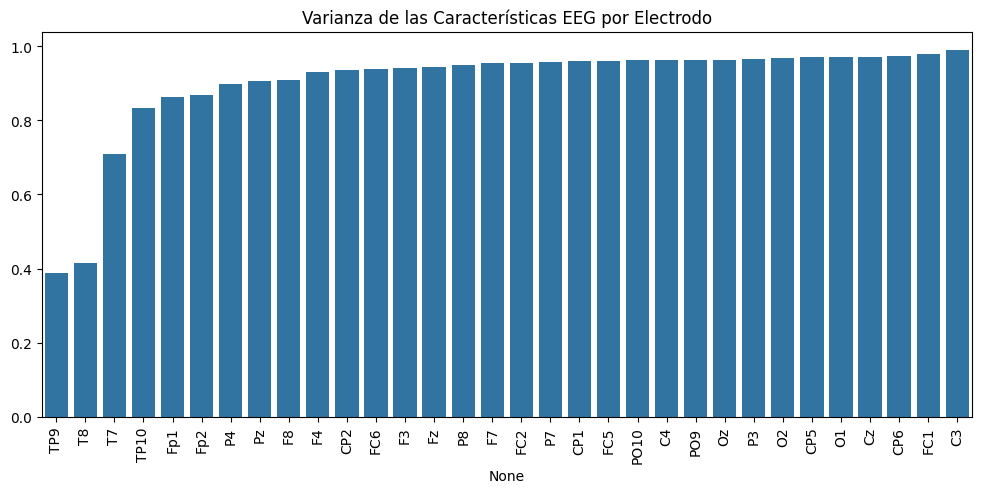

Características antes: 32
Características después de eliminar baja varianza: 32


In [34]:
# Convertir X_train en DataFrame para facilitar el análisis
eeg_df = pd.DataFrame(X_train_filtered, columns=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 
                                        'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 
                                        'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 
                                        'O2', 'PO10'])

# Calcular varianza de cada electrodo
feature_variances = eeg_df.var().sort_values(ascending=True)

# Visualizar la varianza de las características
plt.figure(figsize=(12, 5))
sns.barplot(x=feature_variances.index, y=feature_variances.values)
plt.xticks(rotation=90)
plt.title("Varianza de las Características EEG por Electrodo")
plt.show()


# Aplicar filtro de varianza baja
selector = VarianceThreshold(threshold=0.01)
X_train_var = selector.fit_transform(X_train_filtered)
X_valid_var = selector.transform(X_valid)

print(f"Características antes: {X_train_filtered.shape[1]}")
print(f"Características después de eliminar baja varianza: {X_train_var.shape[1]}")

🟢 **No hay características con suficientemente baja variabilidad como para que sea beneficioso eliminarlas**

## **4. Análisis de Correlaciones**

Si algunas señales EEG están altamente correlacionadas, es posible que sean redundantes. Si hubiera muchas correlaciones superiores a 0.9, aplicaríamos `PCA` para reducir dimensionalidad.

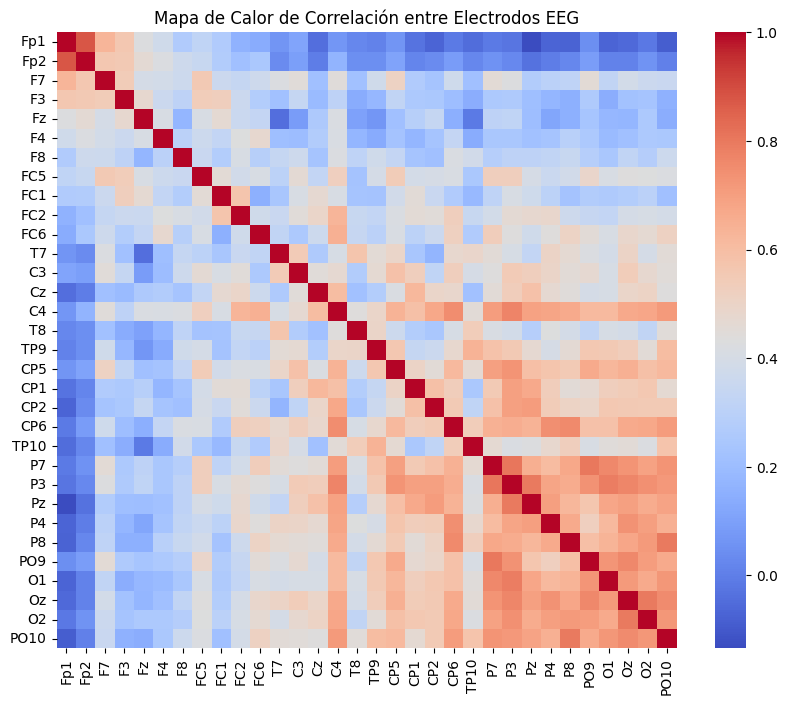

     Electrodo 1 Electrodo 2  Correlación
1            Fp1         Fp2     0.877474
32           Fp2         Fp1     0.877474
727           P7          P3     0.804985
758           P3          P7     0.804985
731           P7         PO9     0.801001
886          PO9          P7     0.801001
1018        PO10          P8     0.799593
863           P8        PO10     0.799593
989           O2          Oz     0.799416
958           Oz          O2     0.799416


In [21]:
# Mapa de calor de correlación entre electrodos
plt.figure(figsize=(10, 8))
sns.heatmap(eeg_df.corr(), cmap="coolwarm", annot=False)
plt.title("Mapa de Calor de Correlación entre Electrodos EEG")
plt.show()

# Calcular la matriz de correlación
correlation_matrix = eeg_df.corr()

# Desenrollar la matriz de correlación en formato de lista ordenada
correlation_unrolled = correlation_matrix.unstack().reset_index()
correlation_unrolled.columns = ["Electrodo 1", "Electrodo 2", "Correlación"]

# Filtrar para quitar la diagonal (correlación de un electrodo consigo mismo siempre es 1)
correlation_unrolled = correlation_unrolled[correlation_unrolled["Electrodo 1"] != correlation_unrolled["Electrodo 2"]]

# Ordenar de mayor a menor
correlation_unrolled = correlation_unrolled.sort_values(by="Correlación", ascending=False)

# Mostrar las 10 correlaciones más altas
print(correlation_unrolled.head(10))

#### **Resultados**
- **No hay señales EEG con correlación > 0.9**, por lo que **NO es necesario aplicar `PCA` por redundancia.**  
- **Algunas señales tienen correlaciones moderadamente altas (~0.8), pero no lo suficientemente extremas para justificar una reducción automática.**  

#### **Conclusión**
🟢 **Mantenemos todas las señales EEG y pasamos a `SelectKBest` para seleccionar las más relevantes.**  
🟢 **Si fuera necesario reducir dimensionalidad manualmente, podríamos eliminar una de las señales de los pares con correlación > 0.8 (ej., eliminar Fp2 y dejar Fp1).**  
🟢 **Si aplicamos `PCA`, será para mejorar la representación de los datos y no para reducir correlaciones.**  

## **5. Selección de características con ANOVA (`SelectKBest`)**

**Seleccionamos las 20 características más relevantes** en cada evento EEG utilizando **`SelectKBest`** con la **métrica ANOVA F-value**. Esto permite reducir la cantidad de datos sin perder información clave.  

Para cada uno de los 6 eventos, **filtramos las características que mejor diferencian entre presencia y ausencia del evento** y guardamos el conjunto de características seleccionadas. 

Luego, analizamos **cuáles características fueron seleccionadas con más frecuencia en todos los eventos**. Si la mayoría son comunes, **usaremos un solo conjunto optimizado**; si hay mucha variabilidad, **mantendremos selecciones individuales por evento**

In [24]:
# Convertir y_train_filtered a un array de NumPy para evitar errores de indexación
y_train_array = y_train_filtered.to_numpy()

# Diccionario para almacenar las características seleccionadas por evento
selected_features = {}

# Lista para almacenar el número de características seleccionadas por evento
event_summary = []

for event in range(y_train_array.shape[1]):  
    k_best = SelectKBest(score_func=f_classif, k=20)  
    X_train_best = k_best.fit_transform(X_train_var, y_train_array[:, event])  
    X_valid_best = k_best.transform(X_valid_var)

    # Guardar las características seleccionadas para este evento
    selected_features[f"Evento_{event+1}"] = (X_train_best, X_valid_best)

    # Obtener las características seleccionadas
    selected_feature_names = np.array(eeg_df.columns)[k_best.get_support()]
    
    # Agregar al resumen
    event_summary.append(
        f"Evento {event+1}: {X_train_best.shape[1]} características seleccionadas\n"
        f"Características más relevantes: {', '.join(selected_feature_names)}"
    )

# Imprimir resumen final de los eventos
print("\n**Resumen de Selección de Características**")
for summary in event_summary:
    print(summary)



# Contar la frecuencia de cada característica en todos los eventos
feature_counter = Counter()

for event in selected_features.keys():
    selected_feature_names = np.array(eeg_df.columns)[k_best.get_support()]
    feature_counter.update(selected_feature_names)

# Filtrar solo las características que aparecen en todos los eventos
common_features = [feat for feat, count in feature_counter.items() if count == len(selected_features)]

# Mostrar resumen mejorado
print("\n**Características Comunes en Todos los Eventos**")
print(", ".join(common_features))

print(f"\nTotal de características comunes: {len(common_features)} de 20 posibles.")
print(f"{len(feature_counter)} características fueron seleccionadas al menos en un evento.")


**Resumen de Selección de Características**
Evento 1: 20 características seleccionadas
Características más relevantes: F7, F3, Fz, FC5, FC6, T7, C4, CP5, CP1, CP2, CP6, P7, P3, Pz, P4, P8, PO9, O1, Oz, O2
Evento 2: 20 características seleccionadas
Características más relevantes: Fp1, Fp2, FC6, C4, T8, TP9, CP5, CP1, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2, PO10
Evento 3: 20 características seleccionadas
Características más relevantes: Fp1, Fp2, FC6, C4, T8, TP9, CP5, CP1, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2, PO10
Evento 4: 20 características seleccionadas
Características más relevantes: Fp1, F7, F8, FC6, C4, T8, TP9, CP1, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2, PO10
Evento 5: 20 características seleccionadas
Características más relevantes: Fp1, Fp2, F7, F3, Fz, F4, FC5, FC1, C3, Cz, C4, CP1, CP2, P7, P3, Pz, P8, PO9, O1, PO10
Evento 6: 20 características seleccionadas
Características más relevantes: Fp1, Fp2, F7, F3, Fz, FC1, FC6, C3, Cz, C4, T8, CP1, CP2, CP

#### **Análisis de la Selección de Características y Decisión Final**
Tras aplicar `SelectKBest` a cada evento, observamos que **las mismas 20 características fueron seleccionadas en todos los eventos**. Esto significa que **no hay variabilidad significativa entre eventos en cuanto a qué electrodos son más informativos**.

#### **¿Qué nos dice este resultado?**
- **No es necesario mantener selecciones individuales por evento**, ya que las características más relevantes son las mismas para todos. 
- Podemos optimizar el modelo usando **un solo conjunto de 20 características comunes**, en lugar de recalcular selecciones específicas para cada evento.  
- Esto simplifica el proceso de entrenamiento y **mejora la eficiencia sin perder información relevante.** 

In [26]:
# Seleccionar las características comunes para todos los eventos
common_feature_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'FC1', 'FC6', 'C3', 'Cz', 'C4', 
                        'T8', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P8', 'O1', 'PO10']

# Filtrar los datos de entrenamiento y validación con estas características
X_train_best = X_train_var[:, [list(eeg_df.columns).index(f) for f in common_feature_names]]
X_valid_best = X_valid_var[:, [list(eeg_df.columns).index(f) for f in common_feature_names]]

# Verificar las dimensiones finales
print(f"Nuevo tamaño de X_train: {X_train_best.shape}")
print(f"Nuevo tamaño de X_valid: {X_valid_best.shape}")

Nuevo tamaño de X_train: (1172937, 20)
Nuevo tamaño de X_valid: (236894, 20)


## **6. Comparación de Modelos**

 Evaluamos si el modelo mejora en comparación con usar todas las características originales.

In [33]:
# Diccionario con los nombres de los eventos
event_names = {
    0: "HandStart",
    1: "FirstDigitTouch",
    2: "BothStartLoadPhase",
    3: "LiftOff",
    4: "Replace",
    5: "BothReleased"
}

# Diccionario para almacenar los resultados AUC por evento
auc_results = {}

print("\n**Comparación de Modelos por Evento**")

for event in range(y_train_array.shape[1]):  
    event_name = event_names[event]  # Obtener el nombre del evento
    print(f"\nEvaluando Modelo para {event_name}...")

    # Seleccionar la etiqueta correspondiente (convertir a 1D)
    y_train_event = y_train_array[:, event]
    
    # Modelo con todas las características
    model_original = LogisticRegression(max_iter=1000)
    auc_score_original = cross_val_score(model_original, X_train_var, y_train_event, cv=5, scoring="roc_auc").mean()

    # Modelo con las características optimizadas
    model_best = LogisticRegression(max_iter=1000)
    auc_score_best = cross_val_score(model_best, X_train_best, y_train_event, cv=5, scoring="roc_auc").mean()

    # Guardar resultados
    auc_results[event_name] = {"Original": auc_score_original, "SelectKBest": auc_score_best}

    # Imprimir resultados del evento
    print(f"AUC Original: {auc_score_original:.4f} | AUC SelectKBest: {auc_score_best:.4f}")

# Mostrar resumen final
print("\n**Resumen Final de AUC-ROC por Evento**")
for event, scores in auc_results.items():
    print(f"{event}: AUC Original = {scores['Original']:.4f} | AUC SelectKBest = {scores['SelectKBest']:.4f}")


**Comparación de Modelos por Evento**

Evaluando Modelo para HandStart...
AUC Original: 0.7552 | AUC SelectKBest: 0.7439

Evaluando Modelo para FirstDigitTouch...
AUC Original: 0.7741 | AUC SelectKBest: 0.7681

Evaluando Modelo para BothStartLoadPhase...
AUC Original: 0.7365 | AUC SelectKBest: 0.7203

Evaluando Modelo para LiftOff...
AUC Original: 0.7485 | AUC SelectKBest: 0.7249

Evaluando Modelo para Replace...
AUC Original: 0.8589 | AUC SelectKBest: 0.8402

Evaluando Modelo para BothReleased...
AUC Original: 0.7839 | AUC SelectKBest: 0.7459

**Resumen Final de AUC-ROC por Evento**
HandStart: AUC Original = 0.7552 | AUC SelectKBest = 0.7439
FirstDigitTouch: AUC Original = 0.7741 | AUC SelectKBest = 0.7681
BothStartLoadPhase: AUC Original = 0.7365 | AUC SelectKBest = 0.7203
LiftOff: AUC Original = 0.7485 | AUC SelectKBest = 0.7249
Replace: AUC Original = 0.8589 | AUC SelectKBest = 0.8402
BothReleased: AUC Original = 0.7839 | AUC SelectKBest = 0.7459


#### **Resumen de Resultados**
- **El modelo con todas las características superó en todos los casos al modelo con SelectKBest.**  
- La diferencia de **AUC-ROC varía entre 0.01 y 0.04 puntos**, siendo más notable en eventos como "BothReleased" y "LiftOff".  
- Esto indica que **eliminar características puede estar afectando negativamente la capacidad del modelo para capturar información relevante.**

#### **Decisión**
🟢 **No utilizaremos SelectKBest**, ya que la reducción de características no mejoró el rendimiento.  
🟢 **Seguiremos trabajando con todas las características originales**, ya que ofrecen mejor AUC en todos los eventos.  